<a href="https://colab.research.google.com/github/ManuP6789/Face-Generator/blob/main/Copy_of_Easy_Convergence_FaceGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to switch to a GPU runtime type, as of 7/29/23 a Colab t4 GPU allows for face generation running on Duncan's Windows 11 12th Gen i7 laptop without its own GPU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install pydrive to load data from Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# dataset link: https://drive.google.com/file/d/1QoGehi9uW41zXAfWh6pEs15p3H-WMWAO/view?usp=sharing

file = drive.CreateFile({'id':"1QoGehi9uW41zXAfWh6pEs15p3H-WMWAO"})
file.GetContentFile('face_generator.zip')

In [ ]:
!unzip face_generator.zip

Archive:  face_generator.zip
  inflating: Face Generator/README.md  
  inflating: Face Generator/blinking.npy  
  inflating: Face Generator/quality.npy  
  inflating: Face Generator/stylegan2_generator.py  
  inflating: Face Generator/stylegan2.py  
  inflating: Face Generator/joy.npy  
  inflating: Face Generator/age.npy  
  inflating: Face Generator/stylegan2_discriminator.py  
  inflating: Face Generator/gender.npy  
  inflating: Face Generator/yaw.npy  
  inflating: Face Generator/tone.npy  
  inflating: Face Generator/.gitignore  
  inflating: Face Generator/__pycache__/stylegan2_generator.cpython-39.pyc  
  inflating: Face Generator/example_latent_changes.ipynb  
  inflating: Face Generator/hairlength.npy  
  inflating: Face Generator/weights/download.py  
  inflating: Face Generator/weights/car_dlatent_avg.npy  
  inflating: Face Generator/weights/church_dlatent_avg.npy  
  inflating: Face Generator/weights/horse_dlatent_avg.npy  
  inflating: Face Generator/weights/ffhq_dlatent

In [ ]:
%cd Face\ Generator

/content/Face Generator


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import glob
import random

from utils.utils_stylegan2 import convert_images_to_uint8

In [ ]:
def generate_and_save_images(images, it, gridSize=3, plot_fig=True):
    plt.close()
    fig = plt.figure(figsize=(9,9))

    for i in range(images.shape[0]):
        plt.subplot(gridSize, gridSize, i+1)
        plt.imshow(images[i])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    fig.tight_layout()
    #plt.savefig('images/image_at_iter_{:04d}.png'.format(it))
    if plot_fig: plt.show()

### Machine configuration

In [ ]:
impl = 'ref' # 'ref' if cuda is not available in your machine
gpu = True # False if tensorflow cpu is used

# Load stylegan2 generator

In [ ]:
from stylegan2_generator import StyleGan2Generator

Step 1: User Input - COMPLETE <br>
a. generating nine random faces in a three by three grid <br>
b. allowing the user to type in a number between 0 and 8 to choose a face <br>
c. printing out the 512 vector used to generate that face

Step 2: Convergence

Create a Dimension class with:

*   A list of previous values selected in that dimension (position of 512 array)
*   A function to add a new value to the list
*   A function to get a new value in that dimension
  *   First, calculate the "best guess" value by finding the weighted average of the previous values, last year we used the linear weighted average where the first selection has weight 1, the second selection has weight 2, etc.
  * Then create an interval around this "best guess" by taking the standard deviation of the previous values. As the standard deviation decreases, the interval of possible values in this dimension gets tighter. Then multiply by some "narrowing constant" that gets smaller after every selection, so that the interval gets smaller over time. This constant will be found from trial and error.
  * Finally, return a random point from this interval or you could return a value found under some sort of Gaussian curve so that the middle of the interval is more likely.

At the beginning, create 512 Dimensions with 0 previous values and a confidence interval from [-1, 1], any value is possible.

Then, follow this loop:


*   Call the "get value" function on each Dimension to create a 512 length array face. Pass this array into the NVIDIA face generation code following the code block above to make a face. Do this x times to create x faces.
*   The user selects a face. Let's assume this face was generated by some array A. For each value from 0 to 511, call the "add value" function of Dimension i, passing in the value A[i].










In [ ]:
class Dimension:
  prevValues = []
  narrowingConstant = 25

  def addValue(self, newValue):
    self.prevValues.append(newValue)

  # take the linear weighted average (first elem has weight 1, second elem has
  # weight 2, etc...)
  def weightedAverage(self):
    bestGuess = 0
    weight = 1
    for val in self.prevValues:
      bestGuess += weight * val
    return bestGuess

  def getValue(self):
    # only narrow after 4 selections
    if len(self.prevValues) < 4:
      return random.uniform(-1, 1)
    else:
      bestGuess = self.weightedAverage()
      confidence = np.std(self.prevValues) * (self.narrowingConstant / (len(self.prevValues) * len(self.prevValues)))
      lowerBound = max(-1, bestGuess - confidence)
      upperBound = min(1, bestGuess + confidence)
      #print("range: ", lowerBound, ", ", upperBound)
      return random.uniform(lowerBound, upperBound)

Loaded ffhq generator weights!


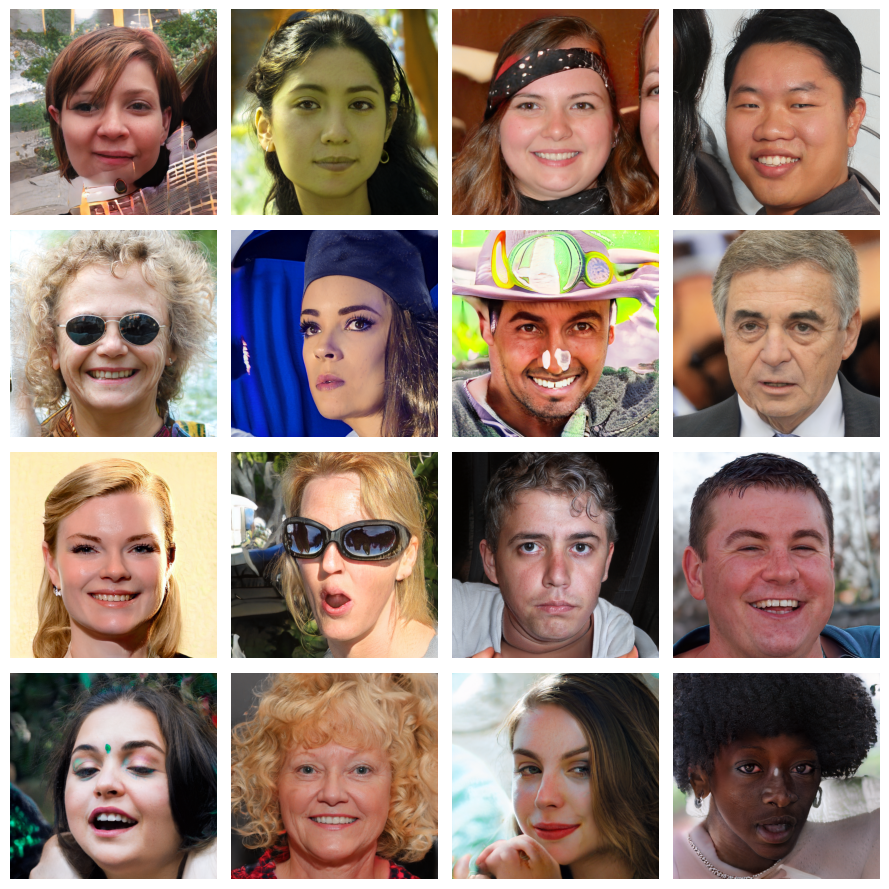

Select a face (0 through 8), -1 to quit: 1


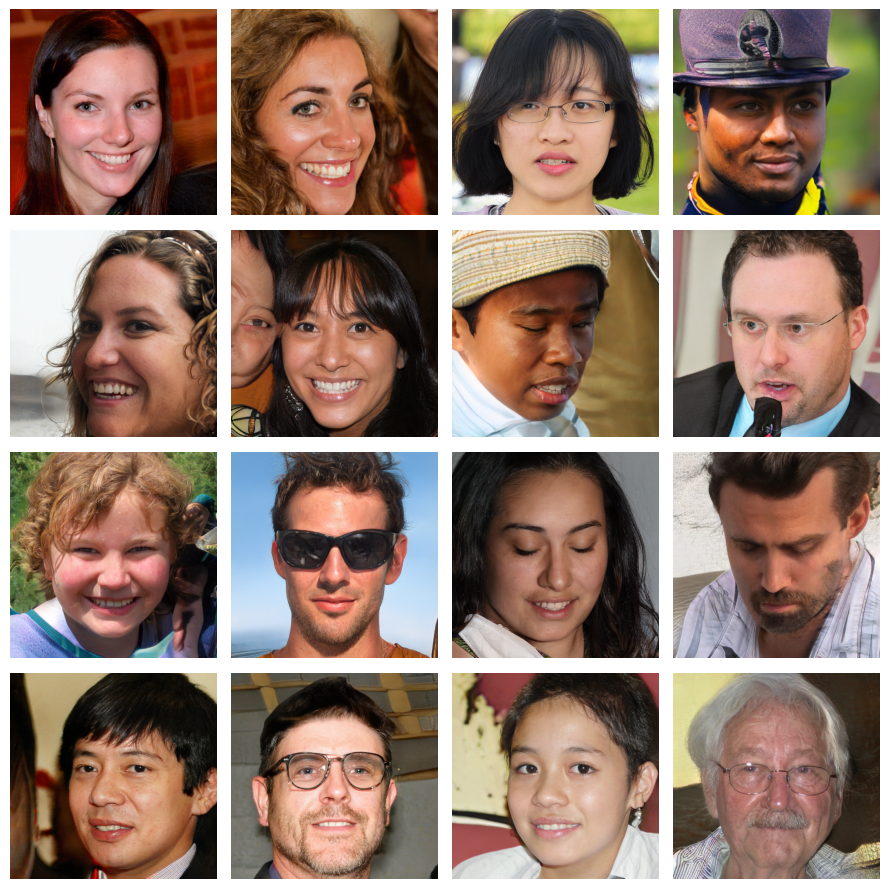

In [ ]:
import time

dimensions = []
for i in range (512):
  dim = Dimension()
  dim.prevValues = []
  dimensions.append(dim)


# makes an array with [numFaces] arrays, where each face is a 512 array
# created by finding one value from each dimension
def generateFaceVectors(numFaces):
  faceVectors = []
  for i in range (numFaces):
    face = []
    for dim in dimensions:
      face.append(dim.getValue())
    faceVectors.append(face)
  return faceVectors


weights_name = 'ffhq' # face model trained by Nvidia

gridSize = 4
faceRes = 256

# instantiating generator network
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu, resolution=faceRes)

userResponse = 0

while userResponse != -1:
  face_vectors = generateFaceVectors(gridSize * gridSize)

  out = generator(face_vectors)
  out_image = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
  generate_and_save_images(out_image.numpy(), 1, gridSize)

  # the input box gets covered by the faces, this is a stupid solution to that:
  time.sleep(3)

  userResponse = int(input("Select a face (0 through 8), -1 to quit: "))
  i = 0
  for dim in dimensions:
    #print(face_vectors[userResponse][i])
    dim.addValue(face_vectors[userResponse][i])
    i = i + 1

In [ ]:
x = Dimension()
x.prevValues = [0.5, 0.3, 0.1, -0.8]
print(x.prevValues)
for i in range (10):
  print(x.getValue())

[0.5, 0.3, 0.1, -0.8]
range:  -0.5210814660734935 ,  0.7210814660734934
0.43538638079543146
range:  -0.5210814660734935 ,  0.7210814660734934
-0.379024677745482
range:  -0.5210814660734935 ,  0.7210814660734934
-0.24947823032632405
range:  -0.5210814660734935 ,  0.7210814660734934
-0.08695915943078025
range:  -0.5210814660734935 ,  0.7210814660734934
-0.24432226865682366
range:  -0.5210814660734935 ,  0.7210814660734934
0.16576802692848736
range:  -0.5210814660734935 ,  0.7210814660734934
0.5085648898039159
range:  -0.5210814660734935 ,  0.7210814660734934
0.22847093877285396
range:  -0.5210814660734935 ,  0.7210814660734934
-0.12884702657101982
range:  -0.5210814660734935 ,  0.7210814660734934
0.21815792776980047


`OLD NVIDIA CODE BELOW THIS ---------------------------------

#### Loading ffhq stylegan2

In [ ]:
weights_name = 'ffhq' # face model trained by Nvidia

# instantiating generator network
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)

# creating random latent vector
seed = 116
rnd = np.random.RandomState(seed)
z = rnd.randn(4, 512).astype('float32')

# running network
out = generator(z)

#converting image to uint8
out_image = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

generate_and_save_images(out_image.numpy(), 0)

NameError: ignored

Vector of 512 numbers for how this face is

In [ ]:
itZ = [[]]
for i in range(512):
  a = np.float32(i / 150).astype('float32')
  itZ[0].append(a)

manualZ = [[0.1, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 1.5, 1.5, 1.3, 1.5, 1.5, 1.3, 1.5, 1.5, 1.3, 1.5, 1.7, 1.3]]

out = generator(manualZ)
out_image = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

generate_and_save_images(out_image.numpy(), 5, plot_fig=False)

Copied and pasted vector of 512 numbers with roughly 20-30 changed semi-randomly (I just went in and scrolled through and changed some numbers)

In [ ]:
itZ = [[]]
for i in range(512):
  a = np.float32(i / 150).astype('float32')
  itZ[0].append(a)

manualZ = [[7.5, 2.5, 1.5, 1.5, 2.5, 0.5, 4.5, 3.5, 6.5, 3.5, 0.5, 2.5, 4.5, 2.5, 2.5, 0.5, 2.5, 6.5, 4.5, 3.5, 1.5, 2.5, 2.5, 1.5, 2.5, 1.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 7.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 3.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 6.5, 2.5, 3.5, 1.5, 5.5, 0.5, 2.5, 3.5, 5.5, 2.5, 0.5, 2.5, 3.5, 6.5, 2.5, 2.5, 2.5, 12.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 0.5, 2.5, 3.5, 1.5, 2.5, 1.5, 1.5, 1.3, 1.5, 1.5, 1.3, 1.5, 1.5, 1.3, 1.5, 1.7, 1.3]]

out = generator(manualZ)
out_image = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

generate_and_save_images(out_image.numpy(), 1, plot_fig=False)

Creating a GIF of a latent vector, not currently useful for still image faces but leaving this here:

In [ ]:
setZ = [[]]

In [ ]:
n_images = 10

for i in tqdm(range(n_images)):
    generate_and_save_images(out_image.numpy(), i, plot_fig=False)

    #moving randomly in the latent space z
    seed = i
    rnd = np.random.RandomState(seed)

    #mofying slightly latent vector and generating new images
    z += rnd.randn(4, 512).astype('float32') / 400
    out = generator(z)
    out_image = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)

# Save GIF

In [ ]:
anim_file = 'images/ffhq_latent.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image_at_iter*.png')
    filenames = sorted(filenames)
    for i,filename in enumerate(filenames):
        if i % 8 != 0:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)